# ISLR- Python Ch6 -- Lab 1: Subset Selection Methods 

- [Load Dataset](#Load-Dataset)
- [6.5.1 Perform Best Subset Selection](#6.5.1-Perform-Best-Subset-Selection)

In [48]:
# perform standard imports
import numpy as np
import pandas as pd
import statsmodels.api as sm
import scipy

from tqdm import tqdm
from operator import itemgetter
from itertools import combinations
from sklearn.linear_model import LinearRegression
from sklearn import cross_validation
from matplotlib import pyplot as plt

%matplotlib inline
plt.style.use('ggplot') # emulate R's pretty plotting

# print numpy arrays with precision 4
np.set_printoptions(precision=4)

## Load Dataset

The 'Hitters' dataset contains statistics for baseball players and their salaries. Some of the rows have missing data we need to locate these rows and drop them from the dataframe.

In [2]:
# Load the Hitters dataset. Pandas offers great flexibillity with dealing with missing values as keywords to 
# pd.read but lets read in all values so we can see how many we are missing.
hitters = pd.read_csv('../../data/Hitters.csv',index_col=0)

# Get the number of players  and the number of players with missing values
print('Hitters contains', len(hitters), 'players.')
num_missing = np.sum(hitters.isnull().any(axis=1))
print('We are missing data for', num_missing, 'players.')

# now remove the missing players for dataframe
hitters = hitters.dropna()
print('After removal Hitters contains', len(hitters), 'players.')
print('Shape=', hitters.shape)
hitters.head()

Hitters contains 322 players.
We are missing data for 59 players.
After removal Hitters contains 263 players.
Shape= (263, 20)


,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
-Alan Ashby,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
-Alvin Davis,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
-Andre Dawson,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
-Andres Galarraga,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
-Alfredo Griffin,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,750.0,A


Notice that columns League, Division and NewLeague are categorical. We will need to make dummy variables for these.

In [3]:
# Create a set of dummy variables for the categoricals
dummies = pd.get_dummies(hitters[['League', 'Division', 'NewLeague']])
dummies.head(2)

,League_A,League_N,Division_E,Division_W,NewLeague_A,NewLeague_N
-Alan Ashby,0,1,0,1,0,1
-Alvin Davis,1,0,0,1,1,0


In [4]:
# Generate new dataframe with new dummy variables
df = hitters.drop(['League', 'Division', 'NewLeague'], axis=1)
# add new dummy variables
df = pd.concat([df, dummies[['League_N', 'Division_W', 'NewLeague_N']]],axis=1)
df.head(2)

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,Salary,League_N,Division_W,NewLeague_N
-Alan Ashby,315,81,7,24,38,39,14,3449,835,69,321,414,375,632,43,10,475,1,1,1
-Alvin Davis,479,130,18,66,72,76,3,1624,457,63,224,266,263,880,82,14,480,0,1,0


## 6.5.1 Perform Best Subset Selection

Best subset selection forms every possible model from the predictors. It then compares models with the same nuber of predictors using RSS or R^2. Once the best model is picked for a given number of predictors, Models with different numbers of predictors are compared using one of the information criteria (AIC, BIC, Adj R^2), or by Cross-validation to select from among the models the model with the lowest TEST MSE.

In general, this method is not used because the computational cost is high. For a model with p-predictors, we must consider 2^p models. As such there is not a 'built-in' sklearn module for doing this. We will write a few helper functions to accomplish model selection.

In [44]:
def best_subsets(dataframe, predictors, response, max_features=8):
    """
    Regresses response onto subsets of the predictors in dataframe. Compares models with equal feature 
    numbers choosing the one with the lowest RSS as the 'best' model for that number of features.
    
    PARAMETERS
    ----------
    dataframe : pandas dataframe obj containing responses and predictors
    predictors : list of column names of dataframe used as features
    response : list of column name of dataframe used as target
    
    RETURNS
    -------
    a list of best models, one per feature number
    
    ex.
    [best 1 feat model, best two feat model] = best_subsets(df, predictors, response, max_features = 2)
    """
    
    def process_linear_model(features):
        """
        Constructs Linear Model Regression of response onto features.
        """
        # Create design Matrix
        X = sm.add_constant(dataframe[features])
        y = dataframe[response]

        model = sm.OLS(y,X).fit()
        RSS = model.ssr
        return (model, RSS)

    def get_best_kth_model(k):
        """
        Returns the model from all models with k-predictors with the lowest RSS.
        """
        results = []

        for combo in combinations(predictors, k):
            # process linear model with this combo of features
            results.append(process_linear_model(list(combo)))

        # sort the models and return the one with the smallest RSS
        return sorted(results, key= itemgetter(1)).pop(0)[0]
    
    models =[]
    for k in tqdm(range(1,max_features+1)):
        models.append(get_best_kth_model(k))
    
    return models

predictors = list(df.columns)
predictors.remove('Salary')
models = best_subsets(df, predictors, ['Salary'], max_features=19)

100%|██████████| 19/19 [22:24<00:00, 70.77s/it]


In [45]:
# The best two variable model has CRBI and Hits as predictors
models[1].params

const   -47.955902
Hits      3.300845
CRBI      0.689899
dtype: float64

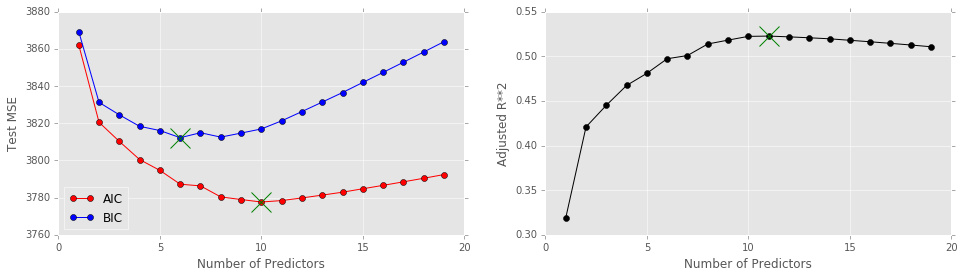

In [75]:
# Now that we have the best models for a given number of varaibles we can compare models with different
# predictors using aic, bic and r_adj. Note AIC and Mallow's Cp are proportional to each other. We will 
# create plots of these statistics to find the best model for baseball player salary.
aics = [models[x].aic for x in range(len(models))]
bics = [models[x].bic for x in range(len(models))]
r_adj = [models[x].rsquared_adj for x in range(len(models))]

# find the mins/maxes
min_aic_index, min_aic = min(enumerate(aics), key=itemgetter(1))
min_bic_index, min_bic = min(enumerate(bics), key=itemgetter(1))
max_radj_index, max_radj = max(enumerate(r_adj), key=itemgetter(1))

num_predictors = np.linspace(1,len(models),len(models))
# Create a plot
fig,(ax1, ax2) = plt.subplots(1,2,figsize=(16,4))
# Add test MSE estimates
ax1.plot(num_predictors, aics, 'r', marker='o', label='AIC');
ax1.plot(num_predictors, bics, 'b', marker='o', label='BIC')

# add the minimums to the axis
ax1.plot(min_aic_index+1, min_aic, 'gx', markersize=20, markeredgewidth=1)
ax1.plot(min_bic_index+1, min_bic, 'gx', markersize=20, markeredgewidth=1)

# Labels and Legend
ax1.set_xlabel('Number of Predictors');
ax1.set_ylabel('Test MSE');
ax1.legend(loc='best');

# Add Adj R**2
ax2.plot(num_predictors, r_adj,'k', marker='o')
ax2.plot(max_radj_index+1, max_radj, 'gx', markersize=20, markeredgewidth=1)
ax2.set_xlabel('Number of Predictors');
ax2.set_ylabel('Adjusted R**2');

So all the estimates of the test error indicate we need a model with more than 5 predictors. The AIC and Adj $R^2$ indicate 10-11 predictors and the BIC statistic indcates 6 predictors.

In [78]:
# The Lowest BIC model has the following coeffecients
models[5].params

const          91.511798
AtBat          -1.868589
Hits            7.604398
Walks           3.697647
CRBI            0.643017
PutOuts         0.264308
Division_W   -122.951534
dtype: float64